In [9]:
import pandas as pd
import os
REPO_ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))
DATA_DIR = os.path.join(REPO_ROOT, "Datasets_all")
# Load datasets
df1 = pd.read_csv(os.path.join(DATA_DIR,"scores_and_weaklink.csv"))
df2 = pd.read_csv(os.path.join(DATA_DIR, "aimoscores.csv"))   
def dataset_overview(df, name="Dataset"):
    print(f"\n===== {name} OVERVIEW =====")
    
    # Basic shape
    print("\nShape:")
    print(f"Rows: {df.shape[0]}")
    print(f"Columns: {df.shape[1]}")
    
    # Column types
    print("\nColumn types:")
    print(df.dtypes)
    
    # Missing values
    print("\nMissing values per column:")
    print(df.isnull().sum())
    
    # Basic statistics
    print("\nBasic statistics:")
    print(df.describe(include='all'))
    
    # Low variance features (almost constant)
    print("\nLow-variance features (possible under-sampled):")
    low_variance = df.nunique()
    print(low_variance[low_variance <= 3])
    
    # Categorical imbalance
    print("\nCategorical value distribution:")
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns
    
    for col in categorical_cols:
        print(f"\nColumn: {col}")
        print(df[col].value_counts(normalize=True))

dataset_overview(df1, "Dataset 1")
dataset_overview(df2, "Dataset 2")



===== Dataset 1 OVERVIEW =====

Shape:
Rows: 2096
Columns: 17

Column types:
ID                               object
Date                             object
SCORE                           float64
ForwardHead                     float64
LeftArmFallForward              float64
RightArmFallForward             float64
LeftShoulderElevation           float64
RightShoulderElevation          float64
ExcessiveForwardLean            float64
LeftAsymmetricalWeightShift     float64
RightAsymmetricalWeightShift    float64
LeftKneeMovesInward             float64
RightKneeMovesInward            float64
LeftKneeMovesOutward            float64
RightKneeMovesOutward           float64
LeftHeelRises                   float64
RightHeelRises                  float64
dtype: object

Missing values per column:
ID                              0
Date                            0
SCORE                           0
ForwardHead                     0
LeftArmFallForward              0
RightArmFallForward           

In [10]:
def find_under_sampled_features(df, threshold=0.05):
    print("\n===== UNDER-SAMPLED FEATURES =====")
    
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns
    
    for col in categorical_cols:
        value_dist = df[col].value_counts(normalize=True)
        rare_values = value_dist[value_dist < threshold]
        
        if not rare_values.empty:
            print(f"\nColumn: {col}")
            print("Rare categories (<5%):")
            print(rare_values)
find_under_sampled_features(df1)


===== UNDER-SAMPLED FEATURES =====

Column: ID
Rare categories (<5%):
ID
cf0e95ab-d6ec-475a-9cc0-c9444b8dd080.Kinect    0.000477
b0cf6cce-156f-42f1-8f04-775d7556233f.Kinect    0.000477
4072bb99-8aa7-4cab-b4de-986865ab47f1.Kinect    0.000477
8452bac0-735d-4eae-8dab-01827e37481d.Kinect    0.000477
5d668b1e-3be1-48cf-836b-f9d327c7b4bf.Kinect    0.000477
                                                 ...   
28a8db8e-d663-4485-a3d1-e35913e8d08b.Kinect    0.000477
315a5309-5f24-4c26-a291-739a1ec0bd25.Kinect    0.000477
5d0810f4-6ecc-41bd-83ba-f512176ddf55.Kinect    0.000477
c86cbd71-962b-4885-96e3-a960bd1e89b9.Kinect    0.000477
8f1b9646-337a-4692-a501-78010c314b4a.Kinect    0.000477
Name: proportion, Length: 2096, dtype: float64

Column: Date
Rare categories (<5%):
Date
7/20/2018     0.042462
8/23/2018     0.041031
5/10/2018     0.030534
7/18/2018     0.028626
6/19/2018     0.028149
                ...   
6/18/2018     0.000477
8/3/2018      0.000477
8/10/2018     0.000477
10/14/2018    

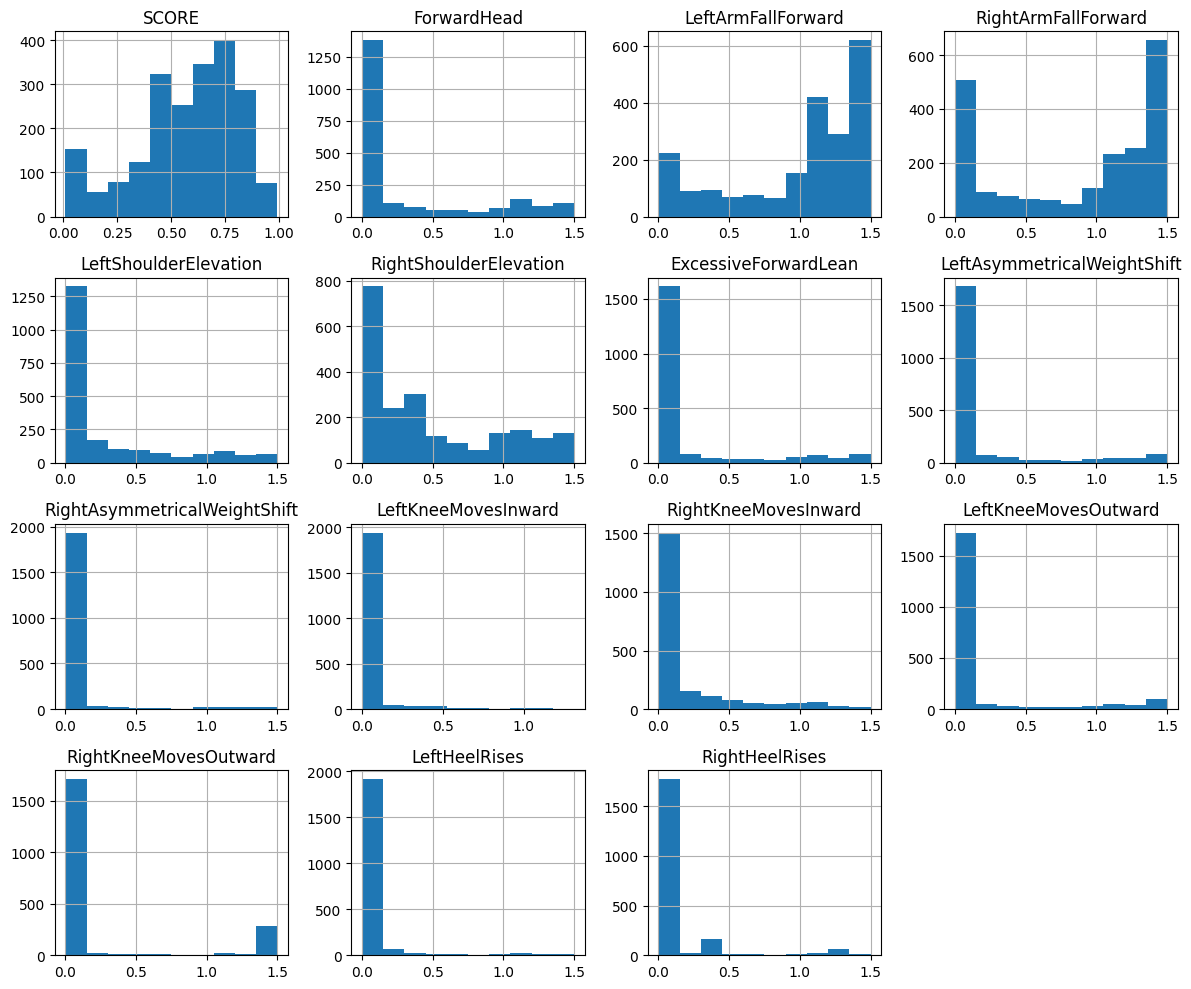

In [11]:
import matplotlib.pyplot as plt

df1.hist(figsize=(12,10))
plt.tight_layout()
plt.show()

In [15]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils import resample


REPO_ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))
DATA_DIR  = os.path.join(REPO_ROOT, "Datasets_all")
OUT_DIR   = os.path.join(os.getcwd(), "data")          # existing 'data' folder next to notebook
os.makedirs(OUT_DIR, exist_ok=True)

# load
df1 = pd.read_csv(os.path.join(DATA_DIR, "scores_and_weaklink.csv"))
df2 = pd.read_csv(os.path.join(DATA_DIR, "aimoscores.csv"))

RANDOM_STATE = 42

# DATASET 1  – will be used for CLASSIFICATION (after merging with df2 on ID)
# No class label yet, so we split now and save; upsampling will be done after
# the merge & label creation step. We still create bootstrap resamples here.

df1_train, df1_test = train_test_split(df1, test_size=0.2, random_state=RANDOM_STATE)

print(f"[DS1] Train: {len(df1_train)} rows | Test: {len(df1_test)} rows")

# Save base splits
df1_train.to_csv(os.path.join(OUT_DIR, "df1_train.csv"), index=False)
df1_test.to_csv(os.path.join(OUT_DIR,  "df1_test.csv"),  index=False)

# Bootstrap resamples from the training set (for ensemble diversity)
N_BOOTSTRAP = 3
for i in range(1, N_BOOTSTRAP + 1):
    boot = resample(df1_train, replace=True, n_samples=len(df1_train), random_state=RANDOM_STATE + i)
    boot.to_csv(os.path.join(OUT_DIR, f"df1_train_bootstrap_{i}.csv"), index=False)
    print(f"  [DS1 Bootstrap {i}] {len(boot)} rows saved.")
    
# DATASET 2  – used for REGRESSION  (target = AimoScore)
# Upsampling for regression = bootstrap resampling (no class imbalance concept)

df2_train, df2_test = train_test_split(df2, test_size=0.2, random_state=RANDOM_STATE)

print(f"\n[DS2] Train: {len(df2_train)} rows | Test: {len(df2_test)} rows")

# Save base splits
df2_train.to_csv(os.path.join(OUT_DIR, "df2_train.csv"), index=False)
df2_test.to_csv(os.path.join(OUT_DIR,  "df2_test.csv"),  index=False)

# ── Upsampling strategy for regression: bootstrap + score-bin-aware resampling
# Bin AimoScore into quartiles; oversample under-represented score ranges
df2_train = df2_train.copy()
df2_train["_score_bin"] = pd.qcut(df2_train["AimoScore"], q=4, labels=False)

bin_counts  = df2_train["_score_bin"].value_counts()
target_size = bin_counts.max()          # upsample all bins to match the largest

upsampled_parts = []
for bin_label, group in df2_train.groupby("_score_bin"):
    if len(group) < target_size:
        group_up = resample(group, replace=True, n_samples=target_size, random_state=RANDOM_STATE)
    else:
        group_up = group
    upsampled_parts.append(group_up)

df2_train_upsampled = pd.concat(upsampled_parts).drop(columns=["_score_bin"]).sample(frac=1, random_state=RANDOM_STATE)
df2_train.drop(columns=["_score_bin"], inplace=True)   # clean original too

df2_train_upsampled.to_csv(os.path.join(OUT_DIR, "df2_train_upsampled.csv"), index=False)
print(f"  [DS2 Upsampled train] {len(df2_train_upsampled)} rows saved.")

# Bootstrap resamples from the upsampled training set
for i in range(1, N_BOOTSTRAP + 1):
    boot = resample(df2_train_upsampled, replace=True,
                    n_samples=len(df2_train_upsampled), random_state=RANDOM_STATE + i)
    boot.to_csv(os.path.join(OUT_DIR, f"df2_train_bootstrap_{i}.csv"), index=False)
    print(f"  [DS2 Bootstrap {i}] {len(boot)} rows saved.")

# Summary
print("\n── Files written to", OUT_DIR, "──")
for f in sorted(os.listdir(OUT_DIR)):
    path = os.path.join(OUT_DIR, f)
    rows = pd.read_csv(path).shape[0]
    print(f"  {f:45s}  {rows:>5} rows")

[DS1] Train: 1676 rows | Test: 420 rows
  [DS1 Bootstrap 1] 1676 rows saved.
  [DS1 Bootstrap 2] 1676 rows saved.
  [DS1 Bootstrap 3] 1676 rows saved.

[DS2] Train: 1675 rows | Test: 419 rows
  [DS2 Upsampled train] 1676 rows saved.
  [DS2 Bootstrap 1] 1676 rows saved.
  [DS2 Bootstrap 2] 1676 rows saved.
  [DS2 Bootstrap 3] 1676 rows saved.

── Files written to /Users/reemothman/Downloads/Data-intensive-systems/A5/data ──
  df1_test.csv                                     420 rows
  df1_train.csv                                   1676 rows
  df1_train_bootstrap_1.csv                       1676 rows
  df1_train_bootstrap_2.csv                       1676 rows
  df1_train_bootstrap_3.csv                       1676 rows
  df2_test.csv                                     419 rows
  df2_train.csv                                   1675 rows
  df2_train_bootstrap_1.csv                       1676 rows
  df2_train_bootstrap_2.csv                       1676 rows
  df2_train_bootstrap_3.csv      

In [16]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split



REPO_ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))
DATA_DIR = os.path.join(REPO_ROOT, "Datasets_all")

OUTPUT_DIR = os.path.join(os.getcwd(), "data")
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Load datasets
df1 = pd.read_csv(os.path.join(DATA_DIR, "scores_and_weaklink.csv"))
df2 = pd.read_csv(os.path.join(DATA_DIR, "aimoscores.csv"))

print("Datasets loaded:")
print("Dataset 1:", df1.shape)
print("Dataset 2:", df2.shape)



# STEP 1 — TRAIN / TEST SPLIT 


train_df1, test_df1 = train_test_split(df1, test_size=0.2, random_state=42)
train_df2, test_df2 = train_test_split(df2, test_size=0.2, random_state=42)

# Save test sets (never touched again)
test_df1.to_csv(os.path.join(OUTPUT_DIR, "dataset1_test.csv"), index=False)
test_df2.to_csv(os.path.join(OUTPUT_DIR, "dataset2_test.csv"), index=False)

print("Train/test split completed.")

# STEP 2 — UPSAMPLING FUNCTION
# (Bootstrap + noise, ID preserved)

def generate_upsampled_datasets(df, n_datasets=10, noise_level=0.01):

    augmented_datasets = []
    
    numeric_cols = df.select_dtypes(include=np.number).columns
    id_cols = [col for col in df.columns if col == "ID"]
    non_numeric_cols = [col for col in df.columns if col not in numeric_cols and col != "ID"]
    
    for i in range(n_datasets):
        
        # Bootstrap sampling
        sampled_df = df.sample(frac=1, replace=True, random_state=42 + i).reset_index(drop=True)
        
        # Add noise ONLY to numeric columns
        noise = np.random.normal(0, noise_level, sampled_df[numeric_cols].shape)
        sampled_df[numeric_cols] = sampled_df[numeric_cols] + noise
        
        augmented_datasets.append(sampled_df)
    
    return augmented_datasets


# STEP 3 — GENERATE UPSAMPLED TRAINING DATASETS

print("Generating upsampled datasets for Dataset 1...")
upsampled_df1_list = generate_upsampled_datasets(train_df1, n_datasets=10, noise_level=0.01)

print("Generating upsampled datasets for Dataset 2...")
upsampled_df2_list = generate_upsampled_datasets(train_df2, n_datasets=10, noise_level=0.01)

# STEP 4 — SAVE UPSAMPLED DATASETS


# Save original training sets
train_df1.to_csv(os.path.join(OUTPUT_DIR, "dataset1_train_original.csv"), index=False)
train_df2.to_csv(os.path.join(OUTPUT_DIR, "dataset2_train_original.csv"), index=False)

# Save augmented datasets
for i, df_aug in enumerate(upsampled_df1_list):
    df_aug.to_csv(os.path.join(OUTPUT_DIR, f"dataset1_train_augmented_{i+1}.csv"), index=False)

for i, df_aug in enumerate(upsampled_df2_list):
    df_aug.to_csv(os.path.join(OUTPUT_DIR, f"dataset2_train_augmented_{i+1}.csv"), index=False)

print("All augmented datasets saved in /data folder.")


Datasets loaded:
Dataset 1: (2096, 17)
Dataset 2: (2094, 43)
Train/test split completed.
Generating upsampled datasets for Dataset 1...
Generating upsampled datasets for Dataset 2...
All augmented datasets saved in /data folder.
